In [1]:
import numpy as np
from jonigrad.layers import *

In [2]:
class MultiHeadAttention(Module):
    def __init__(self, d_model=512, num_heads=8):
        super().__init__()
        assert d_model % num_heads == 0
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.depth = d_model // num_heads

        self.wq = Linear(d_model, d_model)
        self.wk = Linear(d_model, d_model)
        self.wv = Linear(d_model, d_model)

        self.attention = ScaledDPAttention(self.depth)

        self.linear = Linear(d_model, d_model)
        self.norm = LayerNorm((d_model,))

    def split_heads(self, x, batch_size):        
        x = x.reshape(batch_size, -1, self.num_heads, self.depth)
        return x.transpose(0, 2, 1, 3)  # (batch_size, num_heads, seq_len, depth)

    def combine_heads(self, x, batch_size):        
        x = x.transpose(0, 2, 1, 3).reshape(batch_size, -1, self.d_model)  # (batch_size, seq_len, d_model)
        return x
    
    def forward(self, q, k, v, mask=None):
        batch_size = q.shape[1]
        
        q = self.split_heads(self.wq(q), batch_size)
        k = self.split_heads(self.wk(k), batch_size)
        v = self.split_heads(self.wv(v), batch_size)
        
        scaled_attention, _ = self.attention(q, k, v, mask)
        scaled_attention = scaled_attention.transpose(0, 2, 1, 3).reshape(batch_size, -1, self.d_model)  # (batch_size, seq_len, d_model)
        
        output = self.linear(scaled_attention)
        return self.norm(output + q.transpose(0, 2, 1, 3).reshape(output.shape))  

    def backward(self, dL_dy):
        batch_size = dL_dy.shape[0]
        
        # Gradient of the norm layer
        dL_dy_norm = dL_dy

        # Gradient through the final linear layer
        dL_dlinear = self.linear.backward(dL_dy_norm)

        # Reshape back to split heads format
        dL_dlinear_heads = dL_dlinear.reshape(batch_size, -1, self.num_heads, self.depth).transpose(0, 2, 1, 3)
        
        # Gradient through attention mechanism
        dL_dattn_q, dL_dattn_k, dL_dattn_v = self.attention.backward(dL_dlinear_heads)
        
        # Gradient through the input projections
        dL_dq = self.wq.backward(dL_dattn_q.transpose(0, 2, 1, 3).reshape(batch_size, -1, self.d_model))
        dL_dk = self.wk.backward(dL_dattn_k.transpose(0, 2, 1, 3).reshape(batch_size, -1, self.d_model))
        dL_dv = self.wv.backward(dL_dattn_v.transpose(0, 2, 1, 3).reshape(batch_size, -1, self.d_model))
        
        return dL_dq, dL_dk, dL_dv

class ScaledDPAttention(Module):
    def __init__(self, depth):
        super().__init__()
        self.scale = np.sqrt(depth)
        self.softmax = Softmax()
    
    def forward(self, q, k, v, mask=None):
        self.q, self.k, self.v = q, k, v
        self.mask = mask

        self.scores = np.matmul(q, k.transpose(0, 1, 3, 2)) / self.scale
        
        if mask is not None:
            self.mask = mask[:, :, :self.scores.shape[-2], :self.scores.shape[-1]]
            self.scores = np.where(self.mask, self.scores, -1e9)
        
        self.attn = self.softmax(self.scores)
        self.output = np.matmul(self.attn, v)
        return self.output, self.attn
    
    def backward(self, dL_dy):
        # Gradient of the output wrt. attention weights
        dL_dattn = np.matmul(dL_dy, self.v.transpose(0, 1, 3, 2))
        
        # Gradient of the output wrt. v
        dL_dv = np.matmul(self.attn.transpose(0, 1, 3, 2), dL_dy)
        
        # Backward pass through softmax
        datt_scores = self.softmax.backward(dL_dattn)
        
        if self.mask is not None:
            datt_scores = np.where(self.mask, datt_scores, 0)

        # Gradients of the scores wrt. q, k
        dL_dq = np.matmul(datt_scores, self.k) / self.scale
        dL_dk = np.matmul(datt_scores.transpose(0, 1, 3, 2), self.q) / self.scale

        return dL_dq, dL_dk, dL_dv

class LinearLayer(Module):
    def __init__(self, d_model=512, seq_len=100):
        super().__init__()
        self.fc1 = Linear(d_model, d_model)
        self.relu = ReLU()
        self.fc2 = Linear(d_model, d_model)
        self.norm = LayerNorm((d_model,))

    def forward(self, x):
        self.residual = x
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        self.out = self.norm(x + self.residual)
        return self.out

    def backward(self, dL_dy):
        # Gradient of the normalization layer
        dL_dnorm = self.norm.backward(dL_dy)
        
        # Split the gradient at the addition operation
        dL_dresidual = dL_dnorm  # Gradient through the residual connection
        dL_dfc2_input = dL_dnorm  # Gradient through the output of fc2

        # Gradient through the second linear layer
        dL_dfc2 = self.fc2.backward(dL_dfc2_input)
        
        # Gradient through the ReLU activation
        dL_drelu = self.relu.backward(dL_dfc2)
        
        # Gradient through the first linear layer
        dL_dfc1 = self.fc1.backward(dL_drelu)
        
        # Combine gradients from the residual and the main path
        dL_dx = dL_dfc1 + dL_dresidual
        
        return dL_dx


def create_look_ahead_mask(size):
    mask = np.tril(np.ones((size, size), dtype=bool))
    return mask  # Shape (seq_len, seq_len)

def create_padding_mask(seq):
    mask = (seq == 0)
    return mask[:, np.newaxis,:, np.newaxis]


class TransformerDecoder(Module):
    def __init__(self, vocab_size=1000, d_model=512, num_heads=8, seq_len=10):
        super().__init__()
        self.num_heads = num_heads
        self.input_embedding = Embedding(vocab_size, d_model)
        self.positional_embedding = Embedding(seq_len, d_model)
        self.masked_multi_head_attention = MultiHeadAttention(d_model, num_heads)
        self.multi_head_attention = MultiHeadAttention(d_model, num_heads)
        self.linear_layer = LinearLayer(d_model, seq_len)
        self.final_linear = Linear(d_model, vocab_size)  # Final linear layer to project to vocab size
        self.softmax = Softmax()
        
    def forward(self, x, k, v):
        batch_size, seq_len = x.shape
        look_ahead_mask = create_look_ahead_mask(seq_len)
        padding_mask = create_padding_mask(x)

        pos = np.tile(np.arange(seq_len), (batch_size, 1))
        x = self.input_embedding(x) + self.positional_embedding(pos)        
        x = x.transpose(1, 0, 2)  # (batch_size, seq_len, d_model) -> (seq_len, batch_size, d_model)
        
        # Masked multi-head self-attention
        x = self.masked_multi_head_attention(x, x, x, look_ahead_mask[np.newaxis, np.newaxis, :, :])
        x = x.transpose(1, 0, 2)
        # Multi-head attention with encoder output
        x = self.multi_head_attention(x, k.transpose(1, 0, 2), v.transpose(1, 0, 2), padding_mask)
        
        # x = x.transpose(1, 0, 2)  # (seq_len, batch_size, d_model) -> (batch_size, seq_len, d_model)
        
        x = self.linear_layer(x)
        
        logits = self.final_linear(x)  # Project to vocab size
        return self.softmax(logits, -1)

    def backward(self, dL_dy):
        # Backpropagate through the softmax and final linear layer
        dL_dlogits = self.softmax.backward(dL_dy)
        dL_dlinear = self.final_linear.backward(dL_dlogits)
        
        # Backpropagate through the linear layer
        dL_dlinear_layer = self.linear_layer.backward(dL_dlinear)
        
        # Split the gradients for the multi-head attention
        dL_dmh_attention = dL_dlinear_layer
        
        # Backpropagate through the multi-head attention with encoder output
        dL_dmh_attention, dL_dk, dL_dv = self.multi_head_attention.backward(dL_dmh_attention)
        # dL_dmh_attention = dL_dmh_attention.transpose(1, 0, 2)  # (batch_size, seq_len, d_model) -> (seq_len, batch_size, d_model)
        
        # Backpropagate through the masked multi-head self-attention
        dL_dmh_self_attention = dL_dmh_attention
        dL_dmh_self_attention, _, _ = self.masked_multi_head_attention.backward(dL_dmh_self_attention)
        # dL_dmh_self_attention = dL_dmh_self_attention.transpose(1, 0, 2)  # (seq_len, batch_size, d_model) -> (batch_size, seq_len, d_model)
        
        # Since we have residual connections, add gradients from both attentions
        dL_dx = dL_dmh_self_attention
        
        return dL_dx, dL_dk, dL_dv

class TransformerEncoder(Module):
    def __init__(self, vocab_size=1000, d_model=512, num_heads=8, seq_len=10):
        super().__init__()
        self.input_embedding = Embedding(vocab_size, d_model)
        self.positional_embedding = Embedding(seq_len, d_model)
        self.multi_head_attention = MultiHeadAttention(d_model, num_heads)
        self.linear_layer = LinearLayer(d_model, seq_len)
    
    def forward(self, x):
        batch_size, seq_len = x.shape
        pos = np.tile(np.arange(seq_len), (batch_size, 1))
        x = self.input_embedding(x) + self.positional_embedding(pos)

        x = x.transpose(1, 0, 2)  # (batch_size, seq_len, d_model) -> (seq_len, batch_size, d_model)
        x = self.multi_head_attention(x, x, x)
        # x = x.transpose(1, 0, 2)  # (seq_len, batch_size, d_model) -> (batch_size, seq_len, d_model)
        x = self.linear_layer(x)
        return x

    def backward(self, dL_dy):
        # Backpropagate through the linear layer
        dL_dlinear = self.linear_layer.backward(dL_dy)
        
        # Reshape for multi-head attention backward pass
        # dL_dlinear = dL_dlinear.transpose(1, 0, 2)  # (batch_size, seq_len, d_model) -> (seq_len, batch_size, d_model)
        
        # Backpropagate through multi-head attention
        dL_dattn_q, dL_dattn_k, dL_dattn_v = self.multi_head_attention.backward(dL_dlinear)
        
        # The input embeddings and positional embeddings are not updated via gradients directly here,
        # they will be accumulated through the gradient flow.
        
        # No need to explicitly add gradients from positional and input embeddings
        dL_dx = dL_dattn_q.transpose(1, 0, 2)  # (seq_len, batch_size, d_model) -> (batch_size, seq_len, d_model)
        
        return dL_dx


In [3]:
vocab_size1 = 8919
vocab_size2 = 15243
seq_len1 = 127
seq_len2 = 57

d_model = 512
num_heads = 8
batch_size = 4

encoder = TransformerEncoder(vocab_size1, d_model, num_heads, seq_len1)

# Create a sample input (batch_size, seq_len)
sample_input = np.random.randint(0, vocab_size1, (batch_size, seq_len1))
print(sample_input.shape)
# Forward pass
encoder_output = encoder(sample_input)

# Check the encoder_output shape
assert encoder_output.shape == (batch_size, seq_len1, d_model), f"Output shape mismatch: expected {(batch_size, seq_len1, d_model)}, got {encoder_output.shape}"

print("Transformer Encoder test passed!")

# Initialize the decoder
decoder = TransformerDecoder(vocab_size2, d_model, num_heads, seq_len2)

# Create a sample input for the decoder (batch_size, seq_len)
sample_input = np.random.randint(0, vocab_size2, (batch_size, seq_len2))
print(sample_input.shape, encoder_output.shape)
# Forward pass through the decoder
output = decoder(sample_input, encoder_output, encoder_output)

# Check the output shape
assert output.shape == (batch_size, seq_len2, vocab_size2), f"Output shape mismatch: expected {(batch_size, seq_len2, vocab_size2)}, got {output.shape}"

print("Transformer Decoder test passed!")


(4, 127)
Transformer Encoder test passed!
(4, 57) (4, 127, 512)
Transformer Decoder test passed!


In [4]:
output.shape

(4, 57, 15243)

In [6]:
from jonigrad.utils import load_fi_en_translations
from tqdm import tqdm
import matplotlib.pyplot as plt

g = np.random.default_rng()  # create a random generator

D_MODEL = 256
NUM_HEADS = 1
BATCH_SIZE = 32
ITERS = 200
LR = 0.001
THRESHOLD = 5

en_data, en_vocab, fi_data, fi_vocab = load_fi_en_translations(debug=False)

SEQ_LEN_INPUT = en_data.shape[1]
SEQ_LEN_OUTPUT = fi_data.shape[1]
INPUT_VOCAB = len(en_vocab)
OUTPUT_VOCAB = len(fi_vocab)

encoder = TransformerEncoder(INPUT_VOCAB, D_MODEL, NUM_HEADS, SEQ_LEN_INPUT)
decoder = TransformerDecoder(OUTPUT_VOCAB, D_MODEL, NUM_HEADS, SEQ_LEN_OUTPUT)

loss_f = CrossEntropyLoss()
losses = []

encoder.train()
decoder.train()
pbar = tqdm(range(ITERS), desc="Training Progress")
for i in pbar:
    ix = g.integers(low=0, high=en_data.shape[0], size=BATCH_SIZE)
    Xb, Yb = en_data[ix], fi_data[ix]

    encoder.zero_grad()
    decoder.zero_grad()

    encoder_output = encoder(Xb)
    decoder_output = decoder(Yb, encoder_output, encoder_output)

    one_hot_targs = np.eye(OUTPUT_VOCAB)[Yb].astype(np.float32)
    loss = loss_f(decoder_output, one_hot_targs)
    dL_dy = loss_f.backward()

    dL_dx, dL_dk, dL_dv = decoder.backward(dL_dy)
    dL_dx = encoder.backward(dL_dk)

    decoder.clip_grad(THRESHOLD, BATCH_SIZE)
    encoder.clip_grad(THRESHOLD, BATCH_SIZE)

    encoder.step(LR)
    decoder.step(LR)

    losses.append(loss.item())
    pbar.set_postfix({"train_loss": loss.item()})


15243


Training Progress: 100%|██████████| 200/200 [03:00<00:00,  1.11it/s, train_loss=0.000265]


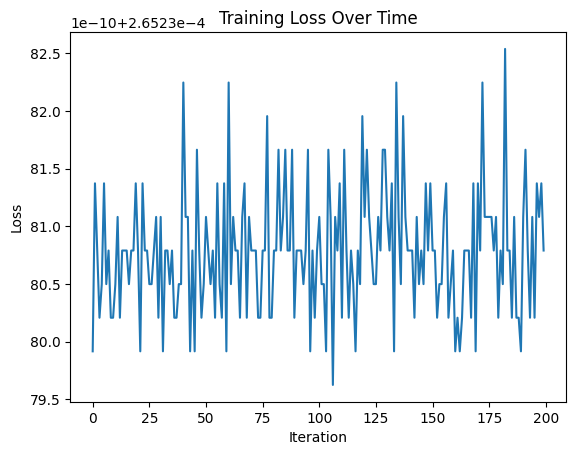

In [7]:
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.show()


In [8]:
def translate_sentence(sentence, src_vocab, trg_vocab, encoder, decoder, max_len=50):
    encoder.eval()
    decoder.eval()

    tokens = [token.lower() for token in sentence.split()]
    tokens = (
        [src_vocab["<SOS>"]]
        + [src_vocab.get(token, src_vocab["<UNK>"]) for token in tokens]
        + [src_vocab["<EOS>"]]
    )

    src_tensor = np.array(tokens).reshape(1, -1)
    encoder_output = encoder(src_tensor)

    trg_indexes = [trg_vocab["<SOS>"]]

    for i in range(max_len):
        trg_tensor = np.array([trg_indexes[-1]]).reshape(1,-1)
        decoder_output = decoder(trg_tensor, encoder_output, encoder_output)

        pred_token = decoder_output.squeeze().argmax(0)
        trg_indexes.append(pred_token)

        if pred_token == trg_vocab["<EOS>"]:
            break

    trg_tokens = [
        list(trg_vocab.keys())[list(trg_vocab.values()).index(i)] for i in trg_indexes
    ]

    return trg_tokens[1:-1]

# Example usage of translate_sentence
sentence = "Hello, how are you?"
translation = translate_sentence(sentence, en_vocab, fi_vocab, encoder, decoder)
print("Translation:", " ".join(translation))

Translation: sivun sivun sivun sivun sivun sivun sivun sivun sivun sivun sivun sivun sivun sivun sivun sivun sivun sivun sivun sivun sivun sivun sivun sivun sivun sivun sivun sivun sivun sivun sivun sivun sivun sivun sivun sivun sivun sivun sivun sivun sivun sivun sivun sivun sivun sivun sivun sivun sivun
